In [1]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import threedigrid
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin

import uuid

In [2]:
from __my_functions_flooddepth_houses import get_time_dimensions_flood
from __my_functions_flooddepth_houses import create_df_flooddepth_houses
from __my_functions_flooddepth_houses import create_sample_houses_withinZone
from __my_functions_flooddepth_houses import calculate_first_qth_arrival_and_maxdepth
from __my_functions_flooddepth_houses import plot_flooddepth_houses_in_zone

### paths

In [3]:
## flood results paths
# floodresults_path = '/Users/louiseklingen/Documents/TU/modelresults/modelresults_denhelder' 
floodresults_path = 'E:/projecten/P2019_1_DenHelderOverstroming/data_en_modellen/modelresults' 

In [4]:
general_path = 'E:\paper2_analysis/depth_arrival_zones'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

-----------------------

### load flood results

In [5]:
# ## flood scenario 
# scenario_name = 'scen1_voorpiek'
# simulation_name = 'lk_dh_test13_5verloop_2d'
# ## start_breach_time = '2000-01-01T18:00:00'
# start_breach_time = '2000-01-01T00:00:00'


scenario_name = 'scen2_napiek'
simulation_name = 'lk_dh_test14_5verloop_38h'
# start_breach_time = '2000-01-02T04:00:00'
start_breach_time = '2000-01-01T00:00:00'

In [6]:
## flood result files
netcdf_file = (f'{floodresults_path}/{simulation_name}/results_3di.nc')
gridadmin_file = (f'{floodresults_path}/{simulation_name}/gridadmin.h5')
gr = GridH5ResultAdmin(gridadmin_file , netcdf_file)
ga = GridH5Admin(gridadmin_file)

In [7]:
time_humanized, last_timestamp  = get_time_dimensions_flood(gr, start_breach_time)

rekentijd: 38.00862374799665 uur
aantal tijdstappen: 457
interval: 300.02, secondes = 5.0 min
 breach start time at: 2000-01-01 00:00:00


----------------

## load buurten and houses in area

In [8]:
buurten_scen2_test = gpd.read_file(f'{input_path}/buurten_scen2_test.shp')
# buurten_scen2_test.columns

In [9]:
houses_all = gpd.read_file(f'{input_path}/huizen_centroid_flood_area_cleaned.shp')

------------------------------------------------------------

##  one random zone for testing

In [ ]:
random_index = 35
selected_zone = buurten_scen2_test.iloc[random_index]
selected_zone_geom = selected_zone.geometry
# selected_zone_geom

In [ ]:
#oude sluis
selected_zone = buurten_scen2_test.loc[buurten_scen2_test.BU_CODE == 'BU04410901']
selected_zone_geom = selected_zone.geometry

#### alle functies los voor debugging

#### 1) create sample

In [ ]:
samplesize = 14
zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone )
print(zone_name)
houses_df.head(1)

In [ ]:
len(houses_df)

#### 2)  compute flood depth(t)at this sample

In [ ]:
if len(flooddepth_time_houses_df.columns) > 0:
    flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                houses_df, gr, time_humanized, last_timestamp, output_path)
    flooddepth_time_houses_df.tail(1)
else:
    continue

#### 3)  compute one value first arrival and max depth for zone

In [ ]:
first_qth_arrival, max_depth = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df)
first_qth_arrival, max_depth 

#### 4) plot flood depth in zone

In [ ]:
plot_flooddepth_houses_in_zone(zone_name,flooddepth_time_houses_df, first_qth_arrival,max_depth, time_humanized)

----------------------------

## selection of zones

In [10]:
len_all_zones = len(buurten_scen2_test)
len_all_zones

90

#### choose sample size

In [11]:
nr_zones_sampling = 8
samplesize_nr_houses_in_zone = 50

In [12]:
selected_zones = buurten_scen2_test.sample(nr_zones_sampling)

In [13]:
zones_maxdepth_arrival_df = selected_zones[["BU_NAAM", 'geometry', 'AANT_INW']].copy()
zones_maxdepth_arrival_df["maxdepth"] = np.nan
zones_maxdepth_arrival_df["maxdepth_qt"] = np.nan
zones_maxdepth_arrival_df["arrival"] = np.nan
zones_maxdepth_arrival_df

,BU_NAAM,geometry,AANT_INW,maxdepth,maxdepth_qt,arrival
50,Koegras-Zuid,"POLYGON ((113640.398 545567.313, 114126.703 54...",40,NaN,NaN,NaN
84,Breezand,"MULTIPOLYGON (((116177.270 547253.550, 116188....",3385,NaN,NaN,NaN
45,Oostoever,"POLYGON ((114936.397 550044.712, 114945.779 55...",10,NaN,NaN,NaN
22,Duinbuurt,"POLYGON ((111099.500 551034.375, 111172.703 55...",1545,NaN,NaN,NaN
64,Noorderhaven,"POLYGON ((112158.102 544476.000, 112220.203 54...",810,NaN,NaN,NaN
13,Indische buurt-Zuid,"POLYGON ((112740.000 552423.813, 112727.398 55...",1080,NaN,NaN,NaN
68,Buitengebied Oudesluis,"POLYGON ((115402.049 539778.121, 115466.601 53...",200,NaN,NaN,NaN
6,Grachtengordel,"POLYGON ((113365.500 552479.625, 113478.602 55...",715,NaN,NaN,NaN


nr houses in Koegras-Zuid: 33
all houses in zones taken
max_depth_qt: 1.4839260565177776
max_depth: 1.5721206498140923
nr houses in Breezand: 2414
too many, therefor sample of 50 houses taken
nr houses in Oostoever: 105
too many, therefor sample of 50 houses taken
nr houses in Duinbuurt: 1416
too many, therefor sample of 50 houses taken
max_depth_qt: 1.2109052921823136
max_depth: 1.7827518915155813
nr houses in Noorderhaven: 124
too many, therefor sample of 50 houses taken
max_depth_qt: 1.108908974370922
max_depth: 1.5031919383719463
nr houses in Indische buurt-Zuid: 765
too many, therefor sample of 50 houses taken
max_depth_qt: 1.9855044120181802
max_depth: 2.0138923965737123
nr houses in Buitengebied Oudesluis: 186
too many, therefor sample of 50 houses taken
max_depth_qt: 0.4119698386239004
max_depth: 0.4264105390841064
nr houses in Grachtengordel: 468
too many, therefor sample of 50 houses taken
max_depth_qt: 1.9773492594390139
max_depth: 2.497092445332744


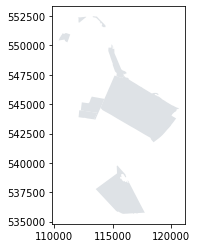

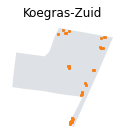

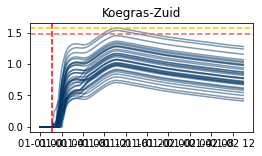

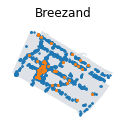

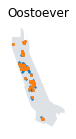

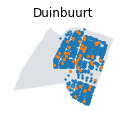

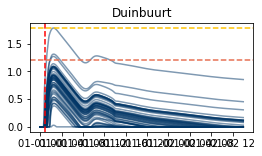

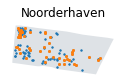

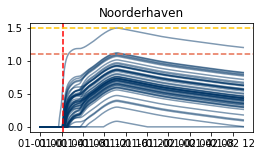

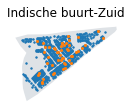

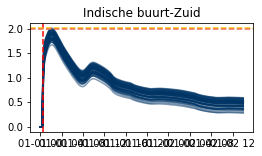

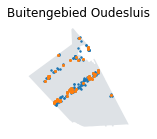

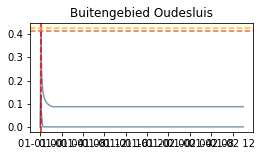

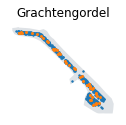

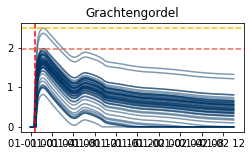

In [14]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

samplesize = samplesize_nr_houses_in_zone

## loop over alle zones
for index, row in zones_maxdepth_arrival_df.iterrows():
    gpd.GeoSeries(row.geometry).plot(ax=ax, color="#dee2e6")
    
    #create sample for all seleced zones
    zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone = row )

    #indien er geen huizen in de zone zijn, continue to next loop
    if len(houses_df) == 0:
        continue
        
    else:
    
        # compute flood depth(t)at this sample
        flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                houses_df, gr, time_humanized, last_timestamp, output_path)
        
        ## continue when no depth
        if len(flooddepth_time_houses_df.columns) == 0:
            continue
            
        else:
            
            # compute one value first arrival and max depth for zone
            first_qth_arrival_dt, max_depth, max_depth_qt  = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df)

            if max_depth > 0:
                zones_maxdepth_arrival_df.loc[index, "maxdepth"] = max_depth
                zones_maxdepth_arrival_df.loc[index, "maxdepth_qt"] = max_depth_qt

            if datetime.timestamp(first_qth_arrival_dt) > 0:
                zones_maxdepth_arrival_df.loc[index, "arrival"] = first_qth_arrival_dt
                
            


        #plot flood depth in zone
        plot_flooddepth_houses_in_zone(zone_name,flooddepth_time_houses_df, first_qth_arrival_dt,max_depth, max_depth_qt, time_humanized, output_path)



In [15]:
zones_maxdepth_arrival_df

,BU_NAAM,geometry,AANT_INW,maxdepth,maxdepth_qt,arrival
50,Koegras-Zuid,"POLYGON ((113640.398 545567.313, 114126.703 54...",40,1.572121,1.483926,2000-01-01 02:16:04
84,Breezand,"MULTIPOLYGON (((116177.270 547253.550, 116188....",3385,NaN,NaN,NaN
45,Oostoever,"POLYGON ((114936.397 550044.712, 114945.779 55...",10,NaN,NaN,NaN
22,Duinbuurt,"POLYGON ((111099.500 551034.375, 111172.703 55...",1545,1.782752,1.210905,2000-01-01 00:50:04
64,Noorderhaven,"POLYGON ((112158.102 544476.000, 112220.203 54...",810,1.503192,1.108909,2000-01-01 04:15:02
13,Indische buurt-Zuid,"POLYGON ((112740.000 552423.813, 112727.398 55...",1080,2.013892,1.985504,2000-01-01 00:25:04
68,Buitengebied Oudesluis,"POLYGON ((115402.049 539778.121, 115466.601 53...",200,0.426411,0.411970,2000-01-01 00:05:10
6,Grachtengordel,"POLYGON ((113365.500 552479.625, 113478.602 55...",715,2.497092,1.977349,2000-01-01 00:45:04


In [16]:
zones_maxdepth_arrival_df_dropna = zones_maxdepth_arrival_df.dropna()

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1)

# df = zones_maxdepth_arrival_df_dropna.copy()

# ax.scatter(df.arrival, df.maxdepth,s = df.AANT_INW, alpha= 0.5 )
# ax.set_xlim(time_humanized[0],time_humanized[80] )

# ax.set_title(f'zones_maxdepth_arrival_df_{scenario_name}') 

# plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}.png', dpi=300)  
# plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}.svg', dpi=300)  


In [ ]:
#datetime to string for export
zones_maxdepth_arrival_df_str = zones_maxdepth_arrival_df.copy()
zones_maxdepth_arrival_df_str['arrival'] = zones_maxdepth_arrival_df["arrival"].apply(str)
zones_maxdepth_arrival_df_str.to_file(f'{output_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses.geojson', drive="GeoJSON")


In [ ]:
def plot_flooddepth_houses_in_zone(zone_name, flooddepth_time_houses_df,first_qth_arrival,max_depths_qth, time_humanized):
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)

    for label, content in flooddepth_time_houses_df.items():
        ax.plot(content, c = '#003566', alpha = 0.5)

    ax.set_xlim(time_humanized[0],time_humanized[40])
    ax.axvline(x = first_qth_arrival, color = 'r', linestyle ='--')
    ax.axhline(max_depths_qth, color= '#ffc300', linestyle ='--')
    plt.title(f'{zone_name}')
